In [1]:
import numpy as np 
import glob
from myvtk.GetMakeVtk import GetMyVtk, makeVtkFile, measure_length
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from PIL import Image, ImageDraw, ImageFont
import cv2

from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from myvtk.srv import square_root_velocity

from sklearn.decomposition import PCA
from scipy.signal import find_peaks
from procrustes import rotational
import pandas as pd
from copy import copy 
from myvtk.General import *
files = glob.glob("./scaling/resamp_attr_ascii/vmtk64a/*.vtk")

#########################################
#    vmtkで計算したcurv, torsを使う      #
#       0.5mmまでresamplingした         # 
#########################################
# files = (glob.glob(".\\scaling\\resamp_attr_ascii\\vmtkgeometry\\*.vtk"))


r = []
pts = []
PTN = []
curvs = []
torss = []
abscs = [] 
Tangents = []
fNormals = []
fBinormals = []

abnormal_shape_filename = [
                        "BG0002",
                        "BH0002",
                        "BH0004",
                        "BH0008",
                        "BH0032",
                        ]

normal_files = []
abnormal_idx = []


for name in abnormal_shape_filename:
    for i in range(len(files)):
        if name in files[i]:
            print (name, files[i])
            abnormal_idx.append(i)
            break   
        else:
            normal_files.append(files[i])
            


normal_files = list(set(normal_files))
print (len(normal_files))

for i in range(len(files)): 
    pt, Curv, Tors, Radius, Abscissas, ptns, ftangent, fnormal, fbinormal = GetMyVtk(files[i], frenet=1)
    if len(pt) != 64:
        print (len(pt), files[i])
        continue
    centroid = np.array([np.mean(pt[:,0]),np.mean(pt[:,1]),np.mean(pt[:,2])])
    pt = pt-centroid
    pts.append(pt)
    r.append(Radius)
    PTN.append(ptns)
    curvs.append(Curv)
    torss.append(Tors)
    abscs.append(Abscissas)
    Tangents.append(ftangent)
    fNormals.append(fnormal)
    fBinormals.append(fbinormal)
    np.save("D:\\!BraVa_src\\src\\Blender\\pt\\{}_{}.npy".format(
        files[i].split("\\")[-1].split("_")[0],
        files[i].split("\\")[-1].split("_")[1]),pt)
    np.save("D:\\!BraVa_src\\src\\Blender\\r\\{}_{}.npy".format(
        files[i].split("\\")[-1].split("_")[0],
        files[i].split("\\")[-1].split("_")[1]),Radius)
pts = np.array(pts)
r = np.array(r)
PTN = np.array(PTN)
curvs=np.array(curvs)
torss = np.array(torss)
abscs= np.array(abscs)
Tangents = np.array(Tangents)
fNormals = np.array(fNormals)
fBinormals = np.array(fBinormals)
print (Tangents.shape)
print (PTN.shape)
print (fBinormals.shape)

BG0002 ./scaling/resamp_attr_ascii/vmtk64a\BG0002_Left_new_new.vtk
BH0002 ./scaling/resamp_attr_ascii/vmtk64a\BH0002_Left_new_new.vtk
BH0004 ./scaling/resamp_attr_ascii/vmtk64a\BH0004_Left_new_new.vtk
BH0008 ./scaling/resamp_attr_ascii/vmtk64a\BH0008_Left_new_new.vtk
BH0032 ./scaling/resamp_attr_ascii/vmtk64a\BH0032_Left_new_new.vtk
84
(104, 64, 3)
(104, 64, 3)
(104, 64, 3)


372.02390961704555
[(0, 0), (1, 0), (2, 0), (3, 1), (4, 2), (5, 3), (6, 4), (7, 5), (8, 5), (9, 6), (10, 7), (11, 8), (12, 9), (13, 10), (14, 11), (15, 12), (15, 13), (16, 14), (17, 15), (17, 16), (18, 17), (19, 18), (20, 19), (21, 20), (22, 21), (23, 22), (24, 23), (25, 24), (26, 25), (27, 26), (28, 27), (29, 28), (30, 29), (31, 30), (32, 31), (33, 32), (34, 33), (35, 34), (36, 35), (37, 36), (38, 37), (39, 38), (40, 39), (41, 40), (42, 41), (43, 42), (44, 43), (45, 44), (46, 45), (47, 46), (48, 47), (49, 48), (50, 49), (51, 50), (52, 51), (53, 52), (54, 53), (55, 54), (56, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63)]


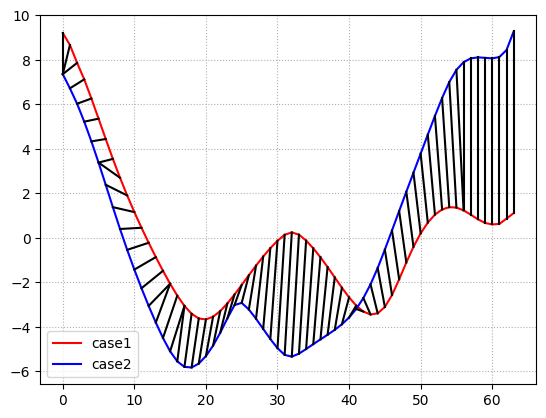

In [7]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Assuming curves is your list of 104 numpy arrays with shape (64,3)
# curves = [np.random.rand(64,3) for _ in range(104)]  # replace this with your actual data

# curve = pts[5]

# Define a function to calculate DTW distance and path
def calculate_dtw(x, y):
    distance, path = fastdtw(x, y, dist=euclidean)
    return distance, path

i = 0
j = np.random.randint(len(files))

coord = 0
#line_a = np.load("./landmark_meanshape.npy")
line_a = pts[i]
line_b = pts[j]
distance, path = calculate_dtw(line_a, line_b)
# warp_paths = path
# warp_paths = [(b,a) for a,b in path]  # reverse path
print (distance)
print (path)

plt.plot(line_a[:,coord],color="red",label="case1")
plt.plot(line_b[:,coord], color="blue",label="case2")
for k in range(len(path)):
    a = path[k][0]
    b = path[k][1]
    # plt.scatter(a,line_a[a][0])
    plt.plot([a,b],[line_a[a][coord],line_b[b][coord]], color="black")
    # plt.arrow(a,b,line_a[a][coord],line_b[b][coord])
    # plt.plot([line_a[a,0], line_b[b,0]])
plt.grid(linestyle=":")
plt.legend()

112


<AxesSubplot: >

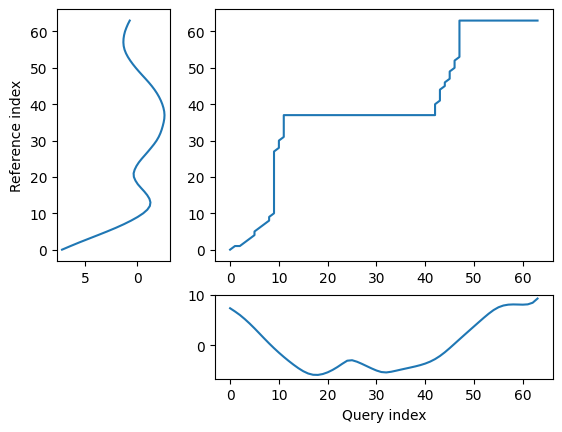

In [22]:
from dtw import *
import numpy as np

# Assuming curves is your list of arrays with shape (64, 3)
# curves = [curve1, curve2, ..., curve104]

# Select a reference curve (for example, the first curve)
reference_curve = np.load("./landmark_meanshape.npy")

# Initialize an empty list to hold the warp functions
warp_functions = []

# Loop over the curves
for curve in pts[j:j+1]:
    # Compute the alignment between the reference curve and the current curve
    alignment = dtw(curve[:,0], reference_curve[:,0],  keep_internals=True)

    # The warp function for each curve is contained in the 'index1' attribute of the alignment object
    warp_function = alignment.index1

    # Append the warp function to the list
    # warp_functions.append(warp_function)

print (len(warp_function))
alignment.plot(type="threeway")# line_a = reference_curve
# line_b = curve
# plt.plot(line_a[:,coord],color="red")
# plt.plot(line_b[:,coord], color="blue")
# for k in range(len(warp_function)):
#     k_warp = warp_function[k]
#     # plt.plot([k,k_warp],[line_a[k],line_b[k_warp]], color="black")
# #     # plt.arrow(a,b,line_a[a][coord],line_b[b][coord])
# #     # plt.plot([line_a[a,0], line_b[b,0]])
# # plt.grid(linestyle=":")

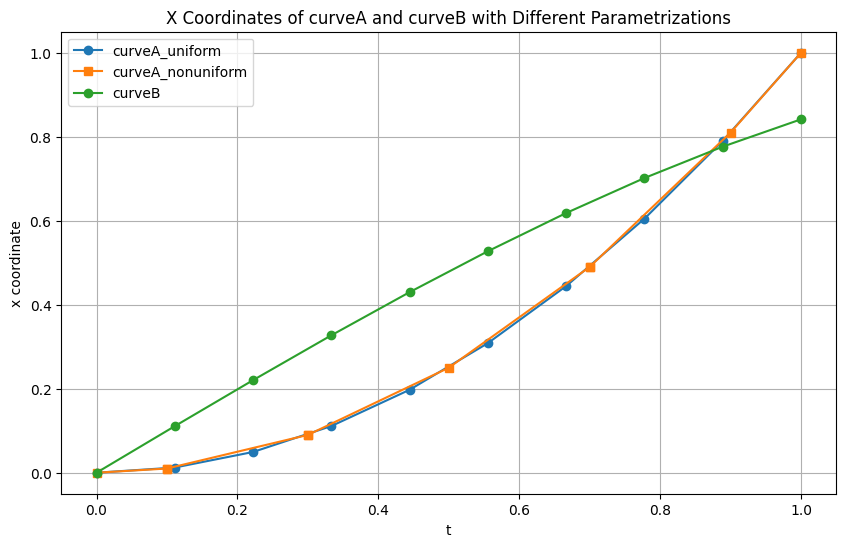

Initial Distance (uniform sampling): 0.6721288390358938
New Distance (non-uniform sampling): 0.7084933997504819


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 定义曲线A和B的参数化
def curveA(t):
    return np.array([t, t**2, t**3])

def curveB(t):
    return np.array([t, np.sin(t), np.cos(t)])

# 计算两点之间的欧氏距离
def distance(point1, point2):
    return np.linalg.norm(point1 - point2)

# 计算两条曲线之间的平均最小距离
def avg_min_distance(curve1, curve2, t_values_curve1, t_values_curve2):
    total_distance = 0
    for t1 in t_values_curve1:
        point1 = curve1(t1)
        distances = [distance(point1, curve2(t2)) for t2 in t_values_curve2]
        total_distance += min(distances)
    return total_distance / len(t_values_curve1)

# 10个离散点
t_values_uniform = np.linspace(0, 1, 10)
t_values_nonuniform = np.sort(np.array([0, 0.1, 0.1, 0.3, 0.3, 0.5, 0.7, 0.7, 0.9, 1]))

# 绘制curveA的x坐标 (使用两种不同的t值采样)
plt.figure(figsize=(10,6))
plt.plot(t_values_uniform, [curveA(t)[1] for t in t_values_uniform], label='curveA_uniform', marker='o')
plt.plot(t_values_nonuniform, [curveA(t)[1] for t in t_values_nonuniform], label='curveA_nonuniform', marker='s')
plt.plot(t_values_uniform, [curveB(t)[1] for t in t_values_uniform], label='curveB', marker='o')
plt.legend()
plt.title("X Coordinates of curveA and curveB with Different Parametrizations")
plt.xlabel("t")
plt.ylabel("x coordinate")
plt.grid(True)
plt.show()

# 计算两次距离
distance_initial = avg_min_distance(curveA, curveB, t_values_uniform, t_values_uniform)
distance_new = avg_min_distance(curveA, curveB, t_values_nonuniform, t_values_uniform)

print("Initial Distance (uniform sampling):", distance_initial)
print("New Distance (non-uniform sampling):", distance_new)
